In [2]:
import os
from random import shuffle

import numpy as np
import imageio

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import filters
from skimage.segmentation import clear_border
from skimage.morphology import closing, square
from skimage.metrics import mean_squared_error

In [3]:
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.filters import rank
from scipy import ndimage as ndi

In [4]:
def get_images(tiles_dir, amount, random=False):
    images = []
    tiles = os.listdir(tiles_dir)
    if random:
        shuffle(tiles)
    for tile in tiles:
        current_tile = tiles_dir + f"/{tile}/"
        images_path = current_tile + "images/"
        mask_path = current_tile + "masks/"
        for image_uri in os.listdir(images_path):
            img = imageio.imread(images_path + image_uri)
            mask = imageio.imread(mask_path + image_uri)

            images.append({"img": img, "label": mask})

            amount -= 1
            if amount <= 0:
                break

        if amount <= 0:
            break

    return images

In [5]:
def apply_threshold(image):

    grayscale = rgb2gray(image)
    thresh = filters.threshold_otsu(grayscale)
    binary = closing(grayscale > thresh, square(3))
    binary = clear_border(binary)

    return binary

In [6]:
def region_segmentation(image):
    gray = rgb2gray(image)
    markers = rank.gradient(gray , disk(5)) < 10
    markers = ndi.label(markers)[0]

    # local gradient (disk(2) is used to keep edges thin)
    gradient = rank.gradient(gray, disk(5))

    gradient2 = np.copy(gradient)
    gradient2[gradient > 128] = 255
    gradient2[gradient <= 128] = 0
    # process the watershed
    # labels = watershed(gradient, markers=markers)

    # display results
    # fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
    #                          sharex=True, sharey=True)
    # ax = axes.ravel()
    #
    # ax[0].imshow(image, cmap=plt.cm.gray)
    # ax[0].set_title("Original")
    #
    # ax[1].imshow(gradient, cmap=plt.cm.gray)
    # ax[1].set_title("Local Gradient")
    #
    # ax[2].imshow(gradient2, cmap=plt.cm.gray)
    # ax[2].set_title("Markers")
    #
    # ax[3].imshow(image, cmap=plt.cm.gray)
    # ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
    # ax[3].set_title("Segmented")

    # for a in ax:
    #     a.axis('off')
    #
    # fig.tight_layout()
    # plt.show()

    return gradient2

In [7]:
def visualise_semantic(images):
    for semantic in images:
        plt.figure(figsize=(32, 32))

        plt.subplot(141)
        plt.title("Original")
        plt.imshow(semantic["img"])

        plt.subplot(142)
        plt.title("Region")
        plt.imshow(semantic["segmentation"][0], cmap=plt.cm.gray)

        plt.subplot(143)
        plt.title("Final")
        plt.imshow(semantic["segmentation"][1], cmap=plt.cm.gray)

        plt.subplot(144)
        plt.title("Label")
        plt.imshow(semantic["label"], cmap=plt.cm.gray)
        plt.show()

        print("Error: ", mean_squared_error(semantic["img"], semantic["label"]))

In [8]:
def segment_images(images):
    semantic_segmentation = []
    for image in images:
        otsu = apply_threshold(image['img'])
        region = region_segmentation(image['img'])
        final = np.ones((image['img'].shape[0], image['img'].shape[1]))
        final[region != 255] = 0
        semantic_segmentation.append({"img": image['img'], "segmentation": [otsu, region, final], "label": image['label']})
    return semantic_segmentation

/var/folders/8t/_rdr32510gq0s7snycd960pm0000gn/T/ipykernel_29179/2673603927.py:3: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  markers = rank.gradient(gray , disk(5)) < 10
/var/folders/8t/_rdr32510gq0s7snycd960pm0000gn/T/ipykernel_29179/2673603927.py:7: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  gradient = rank.gradient(gray, disk(5))


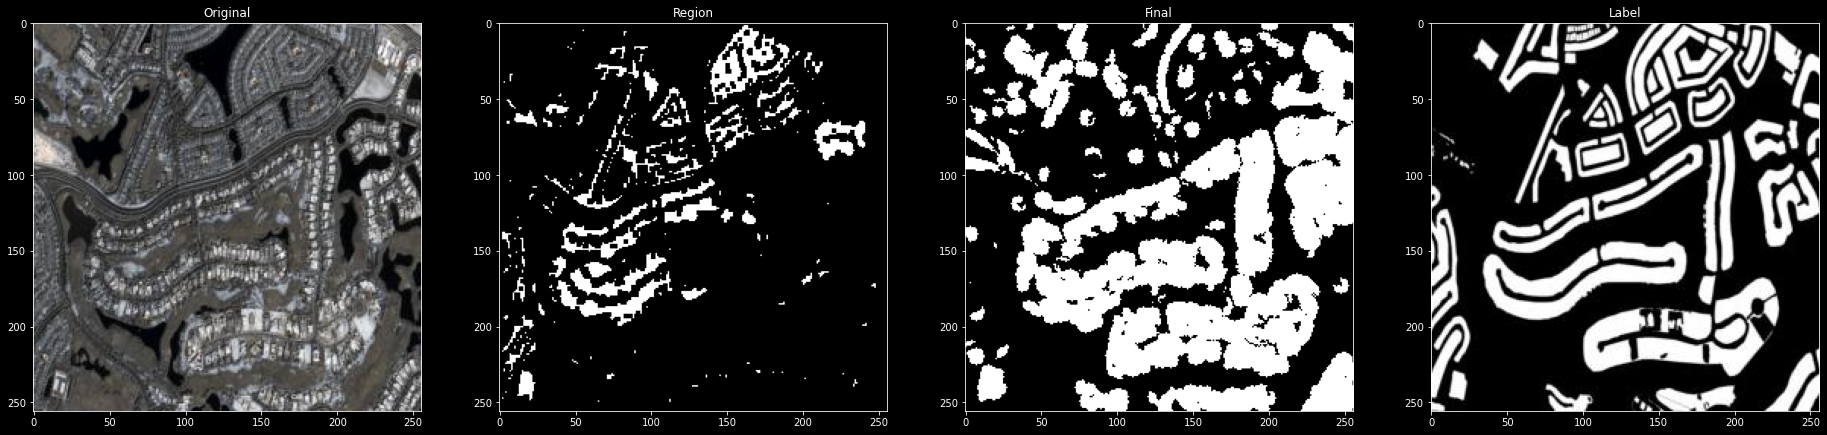

Error:  9851.504999796549


In [30]:
def main():
    images = get_images("data/processed", 1, True)
    semantic_segmentation = segment_images(images)
    visualise_semantic(semantic_segmentation)
if __name__ == "__main__":
    main()